In [ ]:
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [ ]:
team= pd.read_excel("/content/Team.xlsx") #team df 
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [ ]:
league= pd.read_excel("/content/League.xlsx") #league df
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [ ]:
player_stats= pd.read_excel("/content/Player_Attributes.xlsx") #player attributes df
player_stats.drop(player_stats.loc[:, 'potential':'gk_reflexes'].columns, axis = 1, inplace=True) #drop unnecesary attributes; only want overall rating
player_stats.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating
0,1,218353,505942,2016-02-18,67.0
1,2,218353,505942,2015-11-19,67.0
2,3,218353,505942,2015-09-21,62.0
3,4,218353,505942,2015-03-20,61.0
4,5,218353,505942,2007-02-22,61.0


In [ ]:
match= pd.read_excel("/content/Match.xlsx") #match df
match=match.loc[(match['league_id']==1729)] #only Premier League matches
match.drop(match.loc[:, 'goal':'BSA'].columns, axis=1, inplace=True) #drop supplemental statistics from match, such as fouls, yellow/red cards, etc.
match.dropna(inplace=True) #drop rows with Na
match.reset_index(inplace=True) #reset df indices
match.head()

,index,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,1728,1729,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,...,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0
1,1729,1730,1729,1729,2008/2009,1,2008-08-16,489043,9825,8659,...,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0
2,1730,1731,1729,1729,2008/2009,1,2008-08-16,489044,8472,8650,...,37442.0,30617.0,24134.0,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0
3,1731,1732,1729,1729,2008/2009,1,2008-08-16,489045,8654,8528,...,34987.0,35472.0,111865.0,25005.0,35327.0,25150.0,97988.0,41877.0,127857.0,34466.0
4,1733,1734,1729,1729,2008/2009,1,2008-08-16,489047,8668,8655,...,37764.0,19020.0,23921.0,24136.0,30342.0,23889.0,23916.0,23922.0,34176.0,30646.0


In [ ]:
match.shape[0] # number of matches

2962

In [ ]:
match['date']=match['date'].astype('datetime64[D]').values #convert date column from <M8[ns] to datetime64[ns]
player_stats['date']=player_stats['date'].astype('datetime64[D]').values #convert date column from <M8[ns] to datetime64[ns]
def getRating(r,c): #get rating function
  x=match.iloc[r,c] #which player to get rating of in a specific match
  y=player_stats.loc[(player_stats['player_api_id']==x)] #get all ratings of selected player
  y=y.loc[y['date']<match.at[r,'date']] #keep ratings given prior to match date
  z=min(abs(y['date']-match.at[r,'date'])).days #find closest rating date prior to match date
  y=y.loc[abs(y['date']-match.at[r,'date']).astype('timedelta64[D]')==z] #choose newest rating prior to match date
  y.reset_index(inplace=True) #reset index
  return y.loc[0,'overall_rating'] #return rating column

In [ ]:
def getHWidth(k): #get home team widths function 
  section=list() 
  diff=list() 
  i=0 
  j=0 
  mylist = list(match.iloc[k,[13,14,15,16,17,18,19,20,21,22]]) #list of home player X coordinates from specified row, excluding GK  
  for i in range(0, len(mylist)-1): 
    while j<len(mylist)-1 and mylist[j]<mylist[j+1]: 
      section.append(mylist[j])
      j+=1 
      i=j
    section.append(mylist[j])
    diff.append(max(section)-min(section))
    section.clear()
    if j==9:
     break
    j+=1
    i+=1 
  diff = [1.0 if x == 0 else x for x in diff] #if only one player in section, width=0, so make width=1
  return diff #returns list of sectional widths 

In [ ]:
getHWidth(0)

[6.0, 6.0, 2.0]

In [ ]:
def getAWidth(k):#get away team widths function 
  section=list() 
  diff=list() 
  i=0 
  j=0 
  mylist = list(match.iloc[k,[24,25,26,27,28,29,30,31,32,33]]) #list of away player X coordinates from specified row, excluding GK 
  #print(mylist) 
  for i in range(0, len(mylist)-1): 
    while j<len(mylist)-1 and mylist[j]<mylist[j+1]: 
      section.append(mylist[j])
      j+=1 
      i=j
    section.append(mylist[j])
    diff.append(max(section)-min(section))
    section.clear()
    if j==9:
     break
    j+=1
    i+=1 
  diff = [1.0 if x == 0 else x for x in diff] #if only one player in section, width=0, so make width=1
  return diff #returns list of sectional widths 

In [ ]:
def getHDepth(j): #get home team depth function
  x=""
  i=0
  mylist = list(match.iloc[j,[35,36,37,38,39,40,41,42,43,44]]) #list of home player Y coordinates from specified row, excluding GK
  myset = set(mylist) #set of home player Y coordinates, excluding GK
  myset=sorted(myset) #set sorted in ascending order
  while i<len(myset): #go through each index in myset
    x+=str(mylist.count(myset[i])) #count number of times each index in myset appears in mylist to get formation
    i+=1
  return len(x) #return depth of formation, which is number of sections

In [ ]:
getHDepth(0)

3

In [ ]:
def getADepth(j):# get away team depth function
  x=""
  i=0
  mylist = list(match.iloc[j,[46,47,48,49,50,51,52,53,54,55]]) #list of away player Y coordinates from specified row, excluding GK
  myset = set(mylist) #set of away player Y coordinates, excluding GK
  myset=sorted(myset) #set sorted in ascending order
  while i<len(myset): #go through each index in myset
    x+=str(mylist.count(myset[i])) #count number of times each index in myset appears in mylist to get formation
    i+=1
  return len(x) #return depth of formation, which is number of sections

In [ ]:
column_names = ["GK","D1","D2","D3","D4","D5","D6","M1","M2","M3","M4","M5","M6","M7","F1","F2","F3","F4",
                "AGK","AD1","AD2","AD3","AD4","AD5","AD6","AM1","AM2","AM3","AM4","AM5","AM6","AM7","AF1","AF2","AF3","AF4"]
df = pd.DataFrame(index=range(2962),columns=range(36)) #df for player ratings at each position for each match  
df.columns=column_names
df.head()

,GK,D1,D2,D3,D4,D5,D6,M1,M2,M3,...,AM2,AM3,AM4,AM5,AM6,AM7,AF1,AF2,AF3,AF4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
i=0
while i<2962: #go through every match
  j=35 #column to start at for homeplayer ids
  d=1  #column to start inserting defender ratings in df (column D1)
  m=7  #column to start inserting midfielder ratings in df (column M1)
  f=14 #column to start inserting forward ratings in df (column F1)
  mylist = list(match.iloc[i,[35,36,37,38,39,40,41,42,43,44]]) #list of home player Y coordinates from specified row, excluding GK
  myset = set(mylist) #set of home player Y coordinates, excluding GK
  while j<45: #go through each home player id column
    if(match.iloc[i,j]==min(myset)): #if minimum Y, then player is a defender
      df.iloc[i,d]=getRating(i,j+22) #add rating to df
      d+=1 #increment to next defender column in df
    if(match.iloc[i,j]==max(myset)): #if maximum Y, then player is a forward
      df.iloc[i,f]=getRating(i,j+22) #add rating to df
      f+=1 #increment to next forward column in df
    elif((match.iloc[i,j]!=min(myset))&(match.iloc[i,j]!=max(myset))): #if neither, then player is a midfielder
      df.iloc[i,m]=getRating(i,j+22) #add rating to df
      m+=1 #increment to next midfielder column in df
    j+=1
  df.iloc[i,0]=getRating(i,56) #add GK rating to df
  i+=1

In [16]:
i=0
while i<2962: #go through every match
  j=46 #column to start at for away player ids
  d=19 #column to start inserting defender ratings in df (column AD1)
  m=25 #column to start inserting midfielder ratings in df (column AM1)
  f=32 #column to start inserting forward ratings in df (column AF1)
  mylist = list(match.iloc[i,[46,47,48,49,50,51,52,53,54,55]]) #list of away player Y coordinates from specified row, excluding GK
  myset = set(mylist) #set of home player Y coordinates, excluding GK
  while j<56: #go through each away player id column
    if(match.iloc[i,j]==min(myset)): #if minimum Y, then player is a defender
      df.iloc[i,d]=getRating(i,j+22) #add rating to df
      d+=1 #increment to next defender column in df
    if(match.iloc[i,j]==max(myset)): #if maximum Y, then player is a forward
      df.iloc[i,f]=getRating(i,j+22) #add rating to df
      f+=1 #increment to next forward column in df
    elif((match.iloc[i,j]!=min(myset))&(match.iloc[i,j]!=max(myset))): #if neither, then player is a midfielder
      df.iloc[i,m]=getRating(i,j+22) #add rating to df
      m+=1 #increment to next midfielder column in df
    j+=1
  df.iloc[i,18]=getRating(i,67) #add GK rating to df
  i+=1

In [17]:
df.head()

,GK,D1,D2,D3,D4,D5,D6,M1,M2,M3,...,AM2,AM3,AM4,AM5,AM6,AM7,AF1,AF2,AF3,AF4
0,85.0,79.0,88.0,85.0,78.0,NaN,NaN,74.0,83.0,85.0,...,56.0,69.0,75.0,76.0,NaN,NaN,83.0,NaN,NaN,NaN
1,75.0,76.0,85.0,74.0,77.0,NaN,NaN,72.0,79.0,75.0,...,71.0,73.0,72.0,74.0,NaN,NaN,68.0,NaN,NaN,NaN
2,78.0,80.0,71.0,61.0,66.0,NaN,NaN,79.0,78.0,75.0,...,89.0,70.0,80.0,NaN,NaN,NaN,84.0,87.0,NaN,NaN
3,77.0,79.0,79.0,75.0,77.0,NaN,NaN,77.0,72.0,82.0,...,71.0,67.0,79.0,NaN,NaN,NaN,71.0,77.0,NaN,NaN
4,79.0,78.0,80.0,79.0,72.0,NaN,NaN,82.0,72.0,73.0,...,75.0,85.0,77.0,NaN,NaN,NaN,76.0,79.0,NaN,NaN


In [18]:
column_names = ["GK","DEF","MID", "OFF","DEPTH","DEFWIDTH", "MIDWIDTH", "OFFWIDTH","AGK","ADEF","AMID", "AOFF", "ADEPTH","ADEFWIDTH","AMIDWIDTH", "AOFFWIDTH" ,"RESULT" ]
df2=pd.DataFrame(index=range(2962),columns=range(17)) #df for positional ratings, depths, and widths of each team and result for each match
df2.columns=column_names
df2.head()

,GK,DEF,MID,OFF,DEPTH,DEFWIDTH,MIDWIDTH,OFFWIDTH,AGK,ADEF,AMID,AOFF,ADEPTH,ADEFWIDTH,AMIDWIDTH,AOFFWIDTH,RESULT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
i=0
while i<2962: #go through every match
  df2.loc[i,'GK']=int(df.loc[i,'GK']) #add home goalkeeper rating from df into df2
  df2.loc[i,'DEF']=int(np.mean(df.loc[i, 'D1':'D6'])) #add mean of home defender ratings from df into df2
  df2.loc[i,'MID']=int(np.mean(df.loc[i, 'M1':'M7'])) #add mean of home midfielder ratings from df into df2
  df2.loc[i,'OFF']=int(np.mean(df.loc[i, 'F1':'F4'])) #add mean of home attacker ratings from df into df2
  df2.loc[i,'DEPTH']=getHDepth(i) #add home team depth
  df2.loc[i,'DEFWIDTH']=getHWidth(i)[0] #add home team defensive width
  df2.loc[i,'MIDWIDTH']=max(getHWidth(i)[1:len(getHWidth(i))-1]) #add max home team midfield width
  df2.loc[i,'OFFWIDTH']=getHWidth(i)[len(getHWidth(i))-1] #add home team offensive width 
  df2.loc[i,'AGK']=int(df.loc[i,'AGK']) #add away goalkeeper rating from df into df2
  df2.loc[i,'ADEF']=int(np.mean(df.loc[i, 'AD1':'AD6'])) #add mean of away defender ratings from df into df2
  df2.loc[i,'AMID']=int(np.mean(df.loc[i, 'AM1':'AM7'])) #add mean of away midfielder ratings from df into df2
  df2.loc[i,'AOFF']=int(np.mean(df.loc[i, 'AF1':'AF4'])) #add mean of away attacker ratings from df into df2
  df2.loc[i,'ADEPTH']=getADepth(i) # add away team depth 
  df2.loc[i,'ADEFWIDTH']=getAWidth(i)[0] #add away team defensive width
  df2.loc[i,'AMIDWIDTH']=max(getAWidth(i)[1:len(getAWidth(i))-1]) #add max away team midfield width
  df2.loc[i,'AOFFWIDTH']=getAWidth(i)[len(getAWidth(i))-1] #add away team offensive width
  if((match.loc[i,'home_team_goal'])>(match.loc[i,'away_team_goal'])): #if home scored more than away, result is a win, which equals 2
    df2.loc[i,'RESULT']=2
  if((match.loc[i,'home_team_goal'])==(match.loc[i,'away_team_goal'])): #if home scored as much as as away, result is draw, which equals 1
    df2.loc[i,'RESULT']=1
  elif((match.loc[i,'home_team_goal'])<(match.loc[i,'away_team_goal'])): #if home scored less than away, result is a loss, which equals 0
    df2.loc[i,'RESULT']=0
  i+=1
df2.head()

,GK,DEF,MID,OFF,DEPTH,DEFWIDTH,MIDWIDTH,OFFWIDTH,AGK,ADEF,AMID,AOFF,ADEPTH,ADEFWIDTH,AMIDWIDTH,AOFFWIDTH,RESULT
0,85,82,82,82,3,6.0,6.0,2.0,82,77,70,83,4,6.0,6.0,1.0,1
1,75,78,77,80,3,6.0,6.0,2.0,77,69,72,68,3,6.0,4.0,4.0,2
2,78,69,76,74,3,6.0,6.0,2.0,84,75,80,85,3,6.0,6.0,2.0,0
3,77,77,76,75,3,6.0,6.0,2.0,77,72,73,74,3,6.0,6.0,2.0,2
4,79,77,75,81,3,6.0,8.0,1.0,81,77,77,77,3,6.0,4.0,1.0,0


In [ ]:
df2['GK']=df2['GK'].astype(int) #change all column types to int
df2['DEF']=df2['DEF'].astype(int)
df2['MID']=df2['MID'].astype(int)
df2['OFF']=df2['OFF'].astype(int)
df2['DEPTH']=df2['DEPTH'].astype(int)
df2['DEFWIDTH']=df2['DEFWIDTH'].astype(int)
df2['MIDWIDTH']=df2['MIDWIDTH'].astype(int)
df2['OFFWIDTH']=df2['OFFWIDTH'].astype(int)
df2['AGK']=df2['AGK'].astype(int)
df2['ADEF']=df2['ADEF'].astype(int)
df2['AMID']=df2['AMID'].astype(int)
df2['AOFF']=df2['AOFF'].astype(int)
df2['ADEPTH']=df2['ADEPTH'].astype(int)
df2['ADEFWIDTH']=df2['ADEFWIDTH'].astype(int)
df2['AMIDWIDTH']=df2['AMIDWIDTH'].astype(int)
df2['AOFFWIDTH']=df2['AOFFWIDTH'].astype(int)
df2['RESULT']=df2['RESULT'].astype(int)

In [ ]:
#original calculation method 
column_namesv1 = ["NETGK", "NETDEF","NETMID", "NETOFF", "NETDEPTH", "NETDEFWIDTH", "NETMIDWIDTH","NETOFFWIDTH","RESULT" ]
df3v1=pd.DataFrame(index=range(2962),columns=range(9)) #df for goalkeepr ratings, net positional ratings, net depth, net widths, adnd result for each match
df3v1.columns=column_namesv1
df3v1['NETGK']=df2['GK']-df2['AGK'] #add net goalkeeper into df3v1 by subtracting away goalkeeper from home goalkeeper in df2 
df3v1['NETDEF']=df2['DEF']-df2['ADEF'] #add net defense into df3v1 by subtracting away offense from home defense in df2 
df3v1['NETMID']=df2['MID']-df2['AMID'] #add net midfield into df3v1 by subtracting away midfield from home midfield in df2 
df3v1['NETOFF']=df2['OFF']-df2['AOFF'] #add net offense into df3v1 by subtracting away defense from home offense in df2 
df3v1['NETDEPTH']=df2['DEPTH']-df2['ADEPTH'] #add net depth into df3v1 by subtracting away depth from home depth in df2 
df3v1['NETDEFWIDTH']=df2['DEFWIDTH']-df2['ADEFWIDTH'] #add net defense width into df3v1 by subtracting away defense width from home defense width
df3v1['NETMIDWIDTH']=df2['MIDWIDTH']-df2['AMIDWIDTH'] #add net midfield width df3v1 by subtracting away midfield width from home midfield width in df2 
df3v1['NETOFFWIDTH']=df2['OFFWIDTH']-df2['AOFFWIDTH'] #add net offense width into df3v1 by subtracting away offense width from home offense width in df2 
df3v1['RESULT']=df2['RESULT'] #add result from df2 into df3v1
df3v1.head()

In [ ]:
#original classifer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = df3v1.loc[:,'NETGK':'NETOFFWIDTH'].values #independent variables
Y = list(df3v1.RESULT.values) #dependent variables
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.3,random_state=0) #split data into training and test groups
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression
clf.fit(train_x, train_y) #train model
print ('Accuracy: ' + str(clf.score(test_x, test_y)*100) + '%') #check model accuracy with test group

In [23]:
from sklearn import metrics 
y_pred=clf.predict(test_x)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix

array([[127,   0, 114],
       [ 65,   0, 179],
       [ 65,   0, 339]])

Text(0.5, 257.44, 'Predicted label')

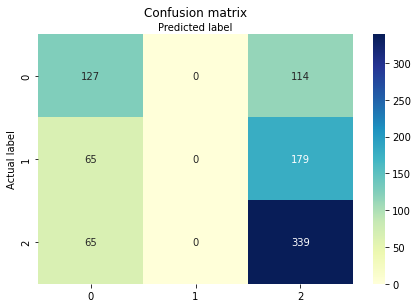

In [24]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
correct_loss_pred = 100*cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]+cnf_matrix[0][2])
correct_draw_pred = 100*cnf_matrix[1][1]/(cnf_matrix[1][0]+cnf_matrix[1][1]+cnf_matrix[1][2])
correct_win_pred = 100*cnf_matrix[2][2]/(cnf_matrix[2][0]+cnf_matrix[2][1]+cnf_matrix[2][2])
print('Percentage of losses correctly classified: ' + str(correct_loss_pred) + '%')
print('Percentage of draws correctly classified: ' + str(correct_draw_pred) + '%')
print('Percentage of wins correctly classified: ' + str(correct_win_pred) + '%')

Percentage of losses correctly classified: 52.697095435684645%
Percentage of draws correctly classified: 0.0%
Percentage of wins correctly classified: 83.91089108910892%


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
for i in range(1, 9):
  clf1 = LogisticRegression(solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression 
  rfe = RFE(estimator=clf1, n_features_to_select=i)   
  fit = rfe.fit(train_x, train_y)
  print('Num Features: '+ str(fit.n_features_))
  print('Selected Features: ' + str(fit.support_))
  print('Feature Ranking: ' + str(fit.ranking_))
  print('Accuracy: '+str(fit.score(test_x, test_y)*100)+'%') #check model accuracy with test group

Num Features: 1
Selected Features: [False False  True False False False False False]
Feature Ranking: [8 6 1 7 3 4 5 2]
Accuracy: 52.75590551181102%
Num Features: 2
Selected Features: [False False  True False False False False  True]
Feature Ranking: [7 5 1 6 2 3 4 1]
Accuracy: 52.64341957255343%
Num Features: 3
Selected Features: [False False  True False  True False False  True]
Feature Ranking: [6 4 1 5 1 2 3 1]
Accuracy: 52.41844769403825%
Num Features: 4
Selected Features: [False False  True False  True  True False  True]
Feature Ranking: [5 3 1 4 1 1 2 1]
Accuracy: 52.41844769403825%
Num Features: 5
Selected Features: [False False  True False  True  True  True  True]
Feature Ranking: [4 2 1 3 1 1 1 1]
Accuracy: 52.75590551181102%
Num Features: 6
Selected Features: [False  True  True False  True  True  True  True]
Feature Ranking: [3 1 1 2 1 1 1 1]
Accuracy: 52.30596175478065%
Num Features: 7
Selected Features: [False  True  True  True  True  True  True  True]
Feature Ranking: [2 1

In [27]:
print('Coefficients: \n', clf.coef_) #negative coeff = increase in the independent variable = decrease in probability of predicting the dependent variable 
#positive coeff = increase in the independent variable = increase in probability of predicting the dependent variable

Coefficients: 
 [[-0.00195503 -0.02176105 -0.0679877   0.00869316  0.05616095  0.01407106
   0.03239092  0.01439711]
 [-0.00482247 -0.01004788  0.0190463  -0.00986904  0.06328954  0.03108686
   0.01387902  0.04825091]
 [ 0.00677751  0.03180892  0.0489414   0.00117588 -0.11945049 -0.04515792
  -0.04626994 -0.06264801]]


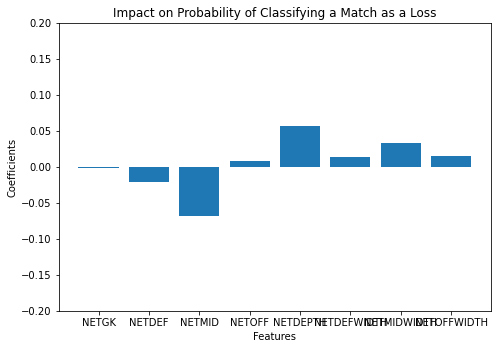

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4],clf.coef_[0][5],clf.coef_[0][6],clf.coef_[0][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Loss")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

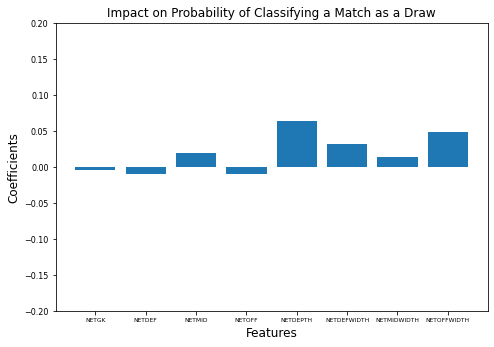

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[1][0],clf.coef_[1][1],clf.coef_[1][2],clf.coef_[1][3],clf.coef_[1][4],clf.coef_[1][5],clf.coef_[1][6],clf.coef_[1][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Draw")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

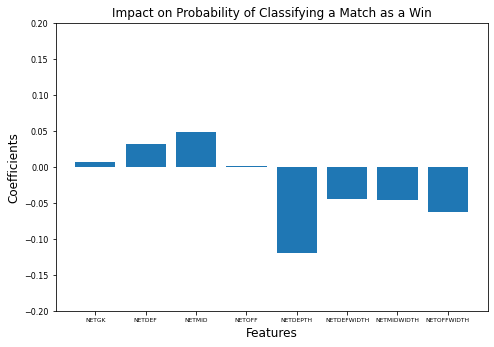

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[2][0],clf.coef_[2][1],clf.coef_[2][2],clf.coef_[2][3],clf.coef_[2][4],clf.coef_[2][5],clf.coef_[2][6],clf.coef_[2][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Win")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [31]:
#updated classifer
X = df3v1.loc[:,'NETGK':'NETOFFWIDTH'].values #independent variables
Y = list(df3v1.RESULT.values) #dependent variables
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.3,random_state=0) #split data into training and test groups
clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression, change class_weight to balanced
clf.fit(train_x, train_y) #train model
print ('Accuracy: ' + str(clf.score(test_x, test_y)*100) + '%') #check model accuracy with test group

Accuracy: 50.168728908886386%


In [32]:
y_pred=clf.predict(test_x)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix

array([[136,  47,  58],
       [ 94,  58,  92],
       [ 87,  65, 252]])

Text(0.5, 257.44, 'Predicted label')

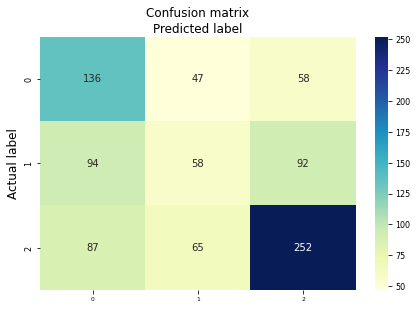

In [33]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
correct_loss_pred = 100*cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]+cnf_matrix[0][2])
correct_draw_pred = 100*cnf_matrix[1][1]/(cnf_matrix[1][0]+cnf_matrix[1][1]+cnf_matrix[1][2])
correct_win_pred = 100*cnf_matrix[2][2]/(cnf_matrix[2][0]+cnf_matrix[2][1]+cnf_matrix[2][2])
print('Percentage of losses correctly classified: ' + str(correct_loss_pred) + '%')
print('Percentage of draws correctly classified: ' + str(correct_draw_pred) + '%')
print('Percentage of wins correctly classified: ' + str(correct_win_pred) + '%')

Percentage of losses correctly classified: 56.43153526970954%
Percentage of draws correctly classified: 23.770491803278688%
Percentage of wins correctly classified: 62.37623762376238%


In [35]:
for i in range(1, 9):
  clf1 = LogisticRegression(class_weight = 'balanced',solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression 
  rfe = RFE(estimator=clf1, n_features_to_select=i)   
  fit = rfe.fit(train_x, train_y)
  print('Num Features: '+ str(fit.n_features_))
  print('Selected Features: ' + str(fit.support_))
  print('Feature Ranking: ' + str(fit.ranking_))
  print('Accuracy: '+str(fit.score(test_x, test_y)*100)+'%') #check model accuracy with test group

Num Features: 1
Selected Features: [False False  True False False False False False]
Feature Ranking: [8 6 1 7 3 4 5 2]
Accuracy: 48.59392575928009%
Num Features: 2
Selected Features: [False False  True False False False False  True]
Feature Ranking: [7 5 1 6 2 3 4 1]
Accuracy: 48.031496062992126%
Num Features: 3
Selected Features: [False False  True False  True False False  True]
Feature Ranking: [6 4 1 5 1 2 3 1]
Accuracy: 47.80652418447694%
Num Features: 4
Selected Features: [False False  True False  True  True False  True]
Feature Ranking: [5 3 1 4 1 1 2 1]
Accuracy: 48.368953880764906%
Num Features: 5
Selected Features: [False False  True False  True  True  True  True]
Feature Ranking: [4 2 1 3 1 1 1 1]
Accuracy: 49.60629921259843%
Num Features: 6
Selected Features: [False  True  True False  True  True  True  True]
Feature Ranking: [3 1 1 2 1 1 1 1]
Accuracy: 50.0562429696288%
Num Features: 7
Selected Features: [False  True  True  True  True  True  True  True]
Feature Ranking: [2 

In [36]:
print('Coefficients: \n', clf.coef_) 

Coefficients: 
 [[-0.00098598 -0.02122025 -0.07115892  0.00948014  0.03937184  0.00308555
   0.02759197  0.0050177 ]
 [-0.0045712  -0.01003069  0.01907934 -0.00983387  0.06297628  0.03224094
   0.01374375  0.04754781]
 [ 0.00555718  0.03125094  0.05207958  0.00035373 -0.10234812 -0.03532649
  -0.04133572 -0.05256551]]


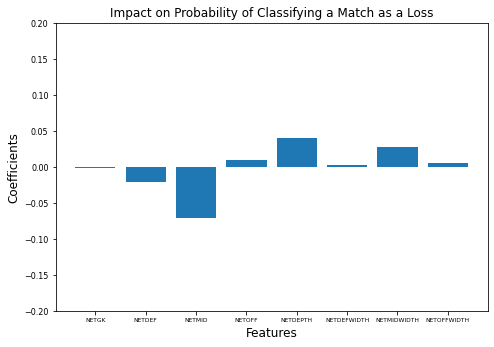

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4],clf.coef_[0][5],clf.coef_[0][6],clf.coef_[0][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Loss")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

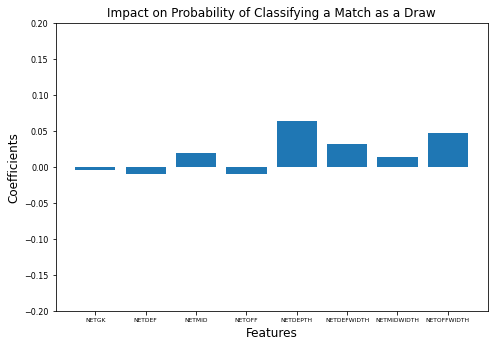

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[1][0],clf.coef_[1][1],clf.coef_[1][2],clf.coef_[1][3],clf.coef_[1][4],clf.coef_[1][5],clf.coef_[1][6],clf.coef_[1][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Draw")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

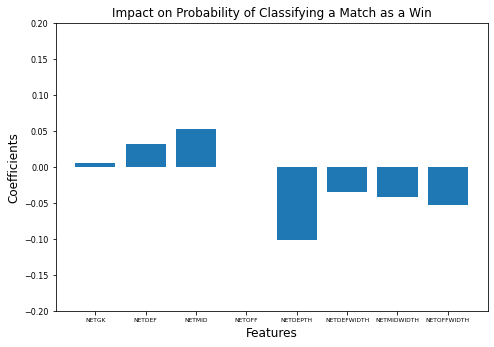

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['NETGK','NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[2][0],clf.coef_[2][1],clf.coef_[2][2],clf.coef_[2][3],clf.coef_[2][4],clf.coef_[2][5],clf.coef_[2][6],clf.coef_[2][7]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Win")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [40]:
#final calculation method
column_names = ["GK","AGK","NETDEF","NETMID", "NETOFF", "NETDEPTH", "NETDEFWIDTH", "NETMIDWIDTH","NETOFFWIDTH","RESULT" ]
df3=pd.DataFrame(index=range(2962),columns=range(10)) #df for goalkeepr ratings, net positional ratings, net depth, net widths, adnd result for each match
df3.columns=column_names
df3['GK']=df2['GK'] #add home goalkeeper rating from df2 into df3
df3['AGK']=df2['AGK'] # add away  rating from df2 into df3
df3['NETDEF']=df2['DEF']-df2['AOFF'] #add net defense into df3 by subtracting away offense from home defense in df2 
df3['NETMID']=df2['MID']-df2['AMID'] #add net midfield into df3 by subtracting away midfield from home midfield in df2 
df3['NETOFF']=df2['OFF']-df2['ADEF'] #add net offense into df3 by subtracting away defense from home offense in df2 
df3['NETDEPTH']=df2['DEPTH']-df2['ADEPTH'] #add net depth into df3 by subtracting away depth from home depth in df2 
df3['NETDEFWIDTH']=df2['DEFWIDTH']-df2['AOFFWIDTH'] #add net defense width into df3 by subtracting away offense width from home defense width
df3['NETMIDWIDTH']=df2['MIDWIDTH']-df2['AMIDWIDTH'] #add net midfield width df3 by subtracting away midfield width from home midfield width in df2 
df3['NETOFFWIDTH']=df2['OFFWIDTH']-df2['ADEFWIDTH'] #add net offense width into df3 by subtracting away defense width from home offense width in df2 
df3['RESULT']=df2['RESULT'] #add result from df2 into df3
df3.head()

,GK,AGK,NETDEF,NETMID,NETOFF,NETDEPTH,NETDEFWIDTH,NETMIDWIDTH,NETOFFWIDTH,RESULT
0,85,82,-1,12,5,-1,5,0,-4,1
1,75,77,10,5,11,0,2,2,-4,2
2,78,84,-16,-4,-1,0,4,0,-4,0
3,77,77,3,3,3,0,4,0,-4,2
4,79,81,0,-2,4,0,5,4,-5,0


In [41]:
#final model
X = df3.loc[:,'GK':'NETOFFWIDTH'].values #independent variables
Y = list(df3.RESULT.values) #dependent variables
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.3,random_state=0) #split data into training and test groups
clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression
clf.fit(train_x, train_y) #train model
print ('Accuracy: ' + str(clf.score(test_x, test_y)*100) + '%') #check model accuracy with test group

Accuracy: 49.9437570303712%


In [42]:
y_pred=clf.predict(test_x)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix

array([[135,  49,  57],
       [ 95,  62,  87],
       [ 88,  69, 247]])

Text(0.5, 257.44, 'Predicted label')

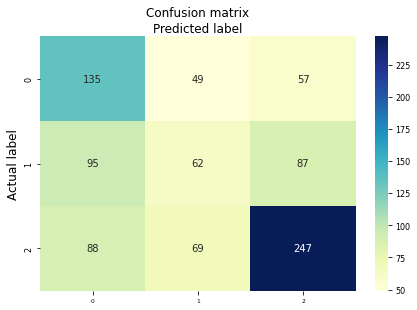

In [43]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
correct_loss_pred = 100*cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]+cnf_matrix[0][2])
correct_draw_pred = 100*cnf_matrix[1][1]/(cnf_matrix[1][0]+cnf_matrix[1][1]+cnf_matrix[1][2])
correct_win_pred = 100*cnf_matrix[2][2]/(cnf_matrix[2][0]+cnf_matrix[2][1]+cnf_matrix[2][2])
print('Percentage of losses correctly classified: ' + str(correct_loss_pred) + '%')
print('Percentage of draws correctly classified: ' + str(correct_draw_pred) + '%')
print('Percentage of wins correctly classifed: ' + str(correct_win_pred) + '%')

Percentage of losses correctly classified: 56.016597510373444%
Percentage of draws correctly classified: 25.40983606557377%
Percentage of wins correctly classifed: 61.13861386138614%


In [45]:
for i in range(1, 10):
  clf1 = LogisticRegression(class_weight = 'balanced',solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression 
  rfe = RFE(estimator=clf1, n_features_to_select=i)   
  fit = rfe.fit(train_x, train_y)
  print('Num Features: '+ str(fit.n_features_))
  print('Selected Features: ' + str(fit.support_))
  print('Feature Ranking: ' + str(fit.ranking_))
  print('Accuracy: '+str(fit.score(test_x, test_y)*100)+'%') #check model accuracy with test group

Num Features: 1
Selected Features: [False False False  True False False False False False]
Feature Ranking: [9 7 8 1 6 3 2 4 5]
Accuracy: 48.59392575928009%
Num Features: 2
Selected Features: [False False False  True False False  True False False]
Feature Ranking: [8 6 7 1 5 2 1 3 4]
Accuracy: 48.818897637795274%
Num Features: 3
Selected Features: [False False False  True False  True  True False False]
Feature Ranking: [7 5 6 1 4 1 1 2 3]
Accuracy: 48.4814398200225%
Num Features: 4
Selected Features: [False False False  True False  True  True  True False]
Feature Ranking: [6 4 5 1 3 1 1 1 2]
Accuracy: 49.38132733408324%
Num Features: 5
Selected Features: [False False False  True False  True  True  True  True]
Feature Ranking: [5 3 4 1 2 1 1 1 1]
Accuracy: 49.493813273340834%
Num Features: 6
Selected Features: [False False False  True  True  True  True  True  True]
Feature Ranking: [4 2 3 1 1 1 1 1 1]
Accuracy: 50.168728908886386%
Num Features: 7
Selected Features: [False  True False  T

In [ ]:
print('Coefficients: \n', clf.coef_) #negative coeff = increase in the independent variable = decrease in probability of predicting the dependent variable 
#positive coeff = increase in the independent variable = increase in probability of predicting the dependent variable

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK',	'NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4],clf.coef_[0][5],clf.coef_[0][6],clf.coef_[0][7],clf.coef_[0][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Loss")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[1][0],clf.coef_[1][1],clf.coef_[1][2],clf.coef_[1][3],clf.coef_[1][4],clf.coef_[1][5],clf.coef_[1][6],clf.coef_[1][7],clf.coef_[1][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Draw")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ('GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH')
coefficients = [clf.coef_[2][0],clf.coef_[2][1],clf.coef_[2][2],clf.coef_[2][3],clf.coef_[2][4],clf.coef_[2][5],clf.coef_[2][6],clf.coef_[2][7],clf.coef_[2][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Win")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
#experimental classifier 1
X = df3.loc[:,'GK':'NETOFFWIDTH'].values #independent variables
Y = list(df3.RESULT.values) #dependent variables
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.3,random_state=0) #split data into training and test groups
clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr', max_iter=10000) #set classifier to multinomial logistic regression, change multi_class to ovr (one vs rest)
clf.fit(train_x, train_y) #train model
print ('Accuracy: ' + str(clf.score(test_x, test_y)*100) + '%') #check model accuracy with test group

In [ ]:
y_pred=clf.predict(test_x)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix

Text(0.5, 257.44, 'Predicted label')

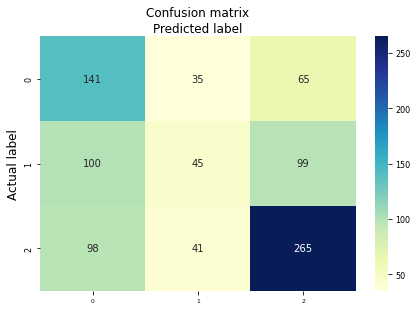

In [52]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [53]:
correct_loss_pred = 100*cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]+cnf_matrix[0][2])
correct_draw_pred = 100*cnf_matrix[1][1]/(cnf_matrix[1][0]+cnf_matrix[1][1]+cnf_matrix[1][2])
correct_win_pred = 100*cnf_matrix[2][2]/(cnf_matrix[2][0]+cnf_matrix[2][1]+cnf_matrix[2][2])
print('Percentage of losses correctly classified: ' + str(correct_loss_pred) + '%')
print('Percentage of draws correctly classified: ' + str(correct_draw_pred) + '%')
print('Percentage of wins correctly classified: ' + str(correct_win_pred) + '%')

Percentage of losses correctly classified: 58.50622406639004%
Percentage of draws correctly classified: 18.442622950819672%
Percentage of wins correctly classified: 65.5940594059406%


In [54]:
for i in range(1, 10):
  clf1 = LogisticRegression(class_weight = 'balanced',solver='lbfgs',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression 
  rfe = RFE(estimator=clf1, n_features_to_select=i)
  fit = rfe.fit(train_x, train_y)
  print('Num Features: '+ str(fit.n_features_))
  print('Selected Features: ' + str(fit.support_))
  print('Feature Ranking: ' + str(fit.ranking_))
  print('Accuracy: '+str(fit.score(test_x, test_y)*100)+'%') #check model accuracy with test group

Num Features: 1
Selected Features: [False False False  True False False False False False]
Feature Ranking: [9 7 8 1 6 3 2 4 5]
Accuracy: 48.59392575928009%
Num Features: 2
Selected Features: [False False False  True False False  True False False]
Feature Ranking: [8 6 7 1 5 2 1 3 4]
Accuracy: 48.818897637795274%
Num Features: 3
Selected Features: [False False False  True False  True  True False False]
Feature Ranking: [7 5 6 1 4 1 1 2 3]
Accuracy: 48.4814398200225%
Num Features: 4
Selected Features: [False False False  True False  True  True  True False]
Feature Ranking: [6 4 5 1 3 1 1 1 2]
Accuracy: 49.38132733408324%
Num Features: 5
Selected Features: [False False False  True False  True  True  True  True]
Feature Ranking: [5 3 4 1 2 1 1 1 1]
Accuracy: 49.493813273340834%
Num Features: 6
Selected Features: [False False False  True  True  True  True  True  True]
Feature Ranking: [4 2 3 1 1 1 1 1 1]
Accuracy: 50.168728908886386%
Num Features: 7
Selected Features: [False  True False  T

In [ ]:
print('Coefficients: \n', clf.coef_) #negative coeff = increase in the independent variable = decrease in probability of predicting the dependent variable 
#positive coeff = increase in the independent variable = increase in probability of predicting the dependent variable

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK',	'NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4],clf.coef_[0][5],clf.coef_[0][6],clf.coef_[0][7],clf.coef_[0][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Loss")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[1][0],clf.coef_[1][1],clf.coef_[1][2],clf.coef_[1][3],clf.coef_[1][4],clf.coef_[1][5],clf.coef_[1][6],clf.coef_[1][7],clf.coef_[1][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Draw")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ('GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH')
coefficients = [clf.coef_[2][0],clf.coef_[2][1],clf.coef_[2][2],clf.coef_[2][3],clf.coef_[2][4],clf.coef_[2][5],clf.coef_[2][6],clf.coef_[2][7],clf.coef_[2][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Win")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
#experimental classifier 2
X = df3.loc[:,'GK':'NETOFFWIDTH'].values #independent variables
Y = list(df3.RESULT.values) #dependent variables
train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size=0.3,random_state=0) #split data into training and test groups
clf = LogisticRegression(class_weight='balanced',solver='saga',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression, change solver to saga
clf.fit(train_x, train_y) #train model
print ('Accuracy: ' + str(clf.score(test_x, test_y)*100) + '%') #check model accuracy with test group

In [ ]:
y_pred=clf.predict(test_x)
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix

In [ ]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
correct_loss_pred = 100*cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]+cnf_matrix[0][2])
correct_draw_pred = 100*cnf_matrix[1][1]/(cnf_matrix[1][0]+cnf_matrix[1][1]+cnf_matrix[1][2])
correct_win_pred = 100*cnf_matrix[2][2]/(cnf_matrix[2][0]+cnf_matrix[2][1]+cnf_matrix[2][2])
print('Percentage of losses correctly classified: ' + str(correct_loss_pred) + '%')
print('Percentage of draws correctly classified: ' + str(correct_draw_pred) + '%')
print('Percentage of wins correctly classified: ' + str(correct_win_pred) + '%')

In [63]:
for i in range(1, 10):
  clf1 = LogisticRegression(class_weight = 'balanced',solver='saga',multi_class='multinomial', max_iter=10000) #set classifier to multinomial logistic regression 
  rfe = RFE(estimator=clf1, n_features_to_select=i)   
  fit = rfe.fit(train_x, train_y)
  print('Num Features: '+ str(fit.n_features_))
  print('Selected Features: ' + str(fit.support_))
  print('Feature Ranking: ' + str(fit.ranking_))
  print('Accuracy: '+str(fit.score(test_x, test_y)*100)+'%') #check model accuracy with test group

Num Features: 1
Selected Features: [False False False  True False False False False False]
Feature Ranking: [9 8 7 1 6 3 2 4 5]
Accuracy: 48.59392575928009%
Num Features: 2
Selected Features: [False False False  True False False  True False False]
Feature Ranking: [8 7 6 1 5 2 1 3 4]
Accuracy: 48.818897637795274%
Num Features: 3
Selected Features: [False False False  True False  True  True False False]
Feature Ranking: [7 6 5 1 4 1 1 2 3]
Accuracy: 48.4814398200225%
Num Features: 4
Selected Features: [False False False  True False  True  True  True False]
Feature Ranking: [6 5 4 1 3 1 1 1 2]
Accuracy: 49.38132733408324%
Num Features: 5
Selected Features: [False False False  True False  True  True  True  True]
Feature Ranking: [5 4 3 1 2 1 1 1 1]
Accuracy: 49.493813273340834%
Num Features: 6
Selected Features: [False False False  True  True  True  True  True  True]
Feature Ranking: [4 3 2 1 1 1 1 1 1]
Accuracy: 50.168728908886386%
Num Features: 7
Selected Features: [False False  True  T

In [ ]:
print('Coefficients: \n', clf.coef_) #negative coeff = increase in the independent variable = decrease in probability of predicting the dependent variable 
#positive coeff = increase in the independent variable = increase in probability of predicting the dependent variable

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK',	'NETDEF','NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.coef_[0][3],clf.coef_[0][4],clf.coef_[0][5],clf.coef_[0][6],clf.coef_[0][7],clf.coef_[0][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Loss")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH']
coefficients = [clf.coef_[1][0],clf.coef_[1][1],clf.coef_[1][2],clf.coef_[1][3],clf.coef_[1][4],clf.coef_[1][5],clf.coef_[1][6],clf.coef_[1][7],clf.coef_[1][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Draw")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()

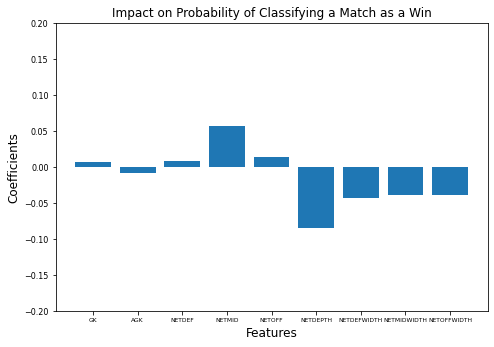

In [67]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ('GK','AGK','NETDEF',	'NETMID',	'NETOFF',	'NETDEPTH',	'NETDEFWIDTH','NETMIDWIDTH','NETOFFWIDTH')
coefficients = [clf.coef_[2][0],clf.coef_[2][1],clf.coef_[2][2],clf.coef_[2][3],clf.coef_[2][4],clf.coef_[2][5],clf.coef_[2][6],clf.coef_[2][7],clf.coef_[2][8]]
ax.bar(features,coefficients)
plt.title("Impact on Probability of Classifying a Match as a Win")
plt.ylim(-0.2,0.2)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.show()